In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lab 6 - Fisher's Linear Discriminant and Logistic Regression
- For equations, refer to Bishop's book, Section 4.1.4 and the slides

# Part I - Fisher's Linear Discriminant for Binary Classification (2 classes)

## Data Generation and Visualisation
- First we'll use scikit-learn to generate 2 blobs of data in 2D, using the [make_blobs()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function.
- The data consists of 600 points divided into 2 classes, 0 and 1.

In [2]:
from sklearn.datasets import make_blobs

In [3]:
X, y = make_blobs(n_samples=600, centers=2, n_features=2, random_state=0)

Let's confirm the data has two classes

In [4]:
np.unique(y)

array([0, 1])

## Exercise 1
- Now create a scatter plot to visualise the generated data. 
- Make sure to paint each point based on the class they belong to, as shown in the Figure below.

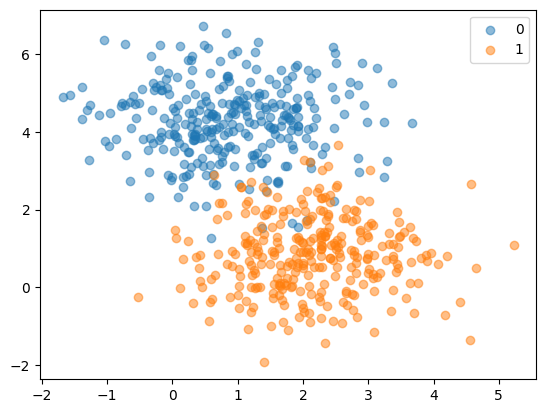

In [5]:
# Scattering the labels
where_y_is_0 = X[y == 0]
where_y_is_1 = X[y == 1]

plt.scatter(where_y_is_0[:, 0], where_y_is_0[:, 1], alpha=0.5, label='0')
plt.scatter(where_y_is_1[:, 0], where_y_is_1[:, 1], alpha=0.5, label='1')

plt.legend()
plt.show()

## Exercise 2
* Now plot a histogram of the data projected on each of the 2 dimensions of $X$ ($0$ and $1$)

As an example, below is a figure that shows the projection on dimension $1$.

_Tips:_ 
* You can either use `histplot()` to generate the plot, in which case it might be easier to pack $X$ and $y$ into a pandas DataFrame.
* Alternatively, considering that you will generate this plot many times throughout this lab, you can write a function that takes the projected vector and the class labels.
* Use 30 bins to obtain a similar plot.

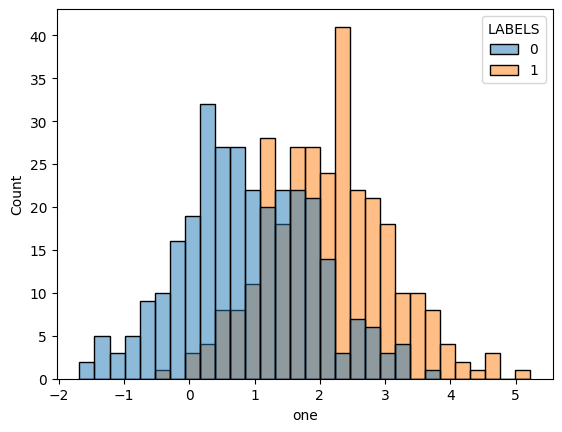

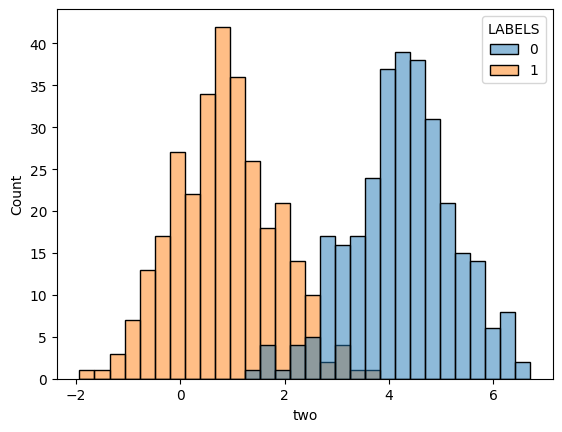

In [6]:
def plot_classes(X: np.ndarray, y: np.ndarray, desired_column: int = 2, xlabel: str = "x", stat: str = "count"):
    df = pd.DataFrame(X, columns=[f'COLUMN {x+1}' for x in range(X.shape[1])])
    labels = pd.Series(y)
    df['LABELS'] = labels

    ax = sns.histplot(df, x=f'COLUMN {desired_column}', hue='LABELS', bins=30, stat=stat)
    ax.set_xlabel(xlabel)
    plt.show()

plot_classes(X, y, 1, 'one')
plot_classes(X, y, 2, 'two')

## Exercise 3 - Implement Fisher's linear discriminant

* Use numpy to calculate $\vec{w}$.
* Plot the data (as you did in Exercise 1), and add a line on the direction of $\vec{w}$ (reference Figure below).
* Project the points onto the calculated vector, and plot the projection (as you did in Exercise 2) (reference Figure below).

In [7]:
def fisher_linear_discriminant(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Calculates the best weight vector for projecting the points

    Args:
        X (np.ndarray): The datapoints matrix
        y (np.ndarray): The target matrix

    Returns:
        np.ndarray: W, the projected vector
    """
    c1_points = X[y == 0]
    c2_points = X[y == 1]

    N1 = len(c1_points)
    m1 = (c1_points.sum(axis=0) / N1).reshape(-1, 1)  # (2, 1)

    N2 = len(c2_points)
    m2 = (c2_points.sum(axis=0) / N2).reshape(-1, 1)  # (2, 1)


    w = np.ones(shape=(m1.shape))  # (2, 1)

    Sw = np.zeros(shape=(w.shape[0], w.shape[0]))  # (2, 2)

    # Sm = (m2 - m1) @ (m2 - m1).T

    for c1_point in c1_points:
        c1_point = c1_point.reshape(-1, 1)
        Sw += (c1_point - m1) @ (c1_point - m1).T
    for c2_point in c2_points:
        c2_point = c2_point.reshape(-1, 1)
        Sw += (c2_point - m2) @ (c2_point - m2).T


    w = np.linalg.inv(Sw) @ (m2 - m1)

    m = ((N1 * m1 + N2 * m2)/len(X))
    w0 = -w.T @ m

    return w, w0[0,0]

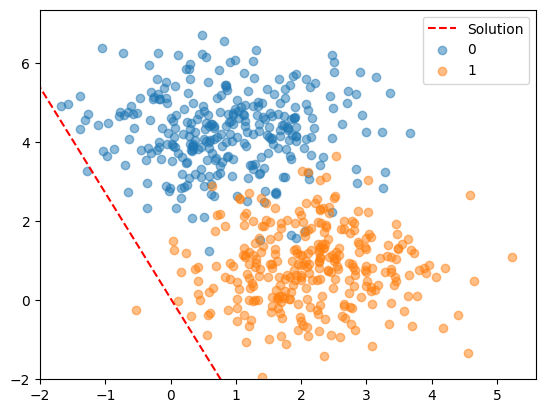

In [8]:
# Scattering the 1 labels
where_y_is_0 = X[y == 0]
where_y_is_1 = X[y == 1]

w, w0 = fisher_linear_discriminant(X, y)

t = np.linspace(-1000, 1000, 100).reshape(-1,1)

x_plot = w[0] * t + w0
y_plot = w[1] * t + w0

plt.plot(x_plot, y_plot, '--', color='red', label='Solution')

plt.scatter(where_y_is_0[:, 0], where_y_is_0[:, 1], alpha=0.5, label='0')
plt.scatter(where_y_is_1[:, 0], where_y_is_1[:, 1], alpha=0.5, label='1')

plt.ylim(bottom=-2)
plt.xlim(left=-2)

plt.legend()
plt.show()

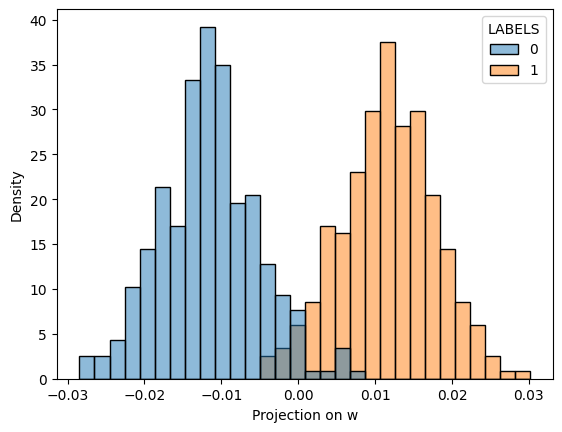

In [9]:
def project_in_w(X, w, w0):
    projection = []
    for point in X:
        point = point.reshape(-1, 1)
        projected = w.T @ point + w0
        projection.append(projected)

    projection = np.array(projection).reshape(-1, 1)
    return projection


projection = project_in_w(X, w, w0)
plot_classes(projection, y, 1, "Projection on w", "density")

## Exercise 4

* In this exercise you will use the `RidgeClassifier` from sklearn (as shown below) to obtain the class predictions from different types of projections:
    * component 0 of the data
    * component 1 of the data
    * the calculated vector $\vec{w}$
    
* Calculate the accuracy of these predictions using `accuracy_score` from sklearn.

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier

In [11]:
# Projecting on the first dimension
r_1_dim = RidgeClassifier()
projection_1_dim = project_in_w(X, np.array([1, 0]), 0)
r_1_dim.fit(projection_1_dim, y)
predicted_y_1_dim = r_1_dim.predict(projection_1_dim)
accuracy_1_dim = accuracy_score(predicted_y_1_dim, y)

# Projecting on the second dimension
r_2_dim = RidgeClassifier()
projection_2_dim = project_in_w(X, np.array([0, 1]), 0)
r_2_dim.fit(projection_2_dim, y)
predicted_y_2_dim = r_2_dim.predict(projection_2_dim)
accuracy_2_dim = accuracy_score(predicted_y_2_dim, y)

# The projection on W
r = RidgeClassifier()
r.fit(projection, y)
predicted_y = r.predict(projection)
accuracy = accuracy_score(predicted_y, y)

print(f"Projection on 1º dimension, score: {accuracy_1_dim}")
print(f"Projection on 2º dimension, score: {accuracy_2_dim}")
print(f"Projection on w, score: {accuracy}")

Projection on 1º dimension, score: 0.7366666666666667
Projection on 2º dimension, score: 0.955
Projection on w, score: 0.965


# Part II - Generalised Linear Discriminant (multi-class)

**NOTE:** For this part you will be using a multi-class estimator from scikit-learn (read the [documentation](https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda)).

## Exercise 1 - Generate data

* Generate a 3 classes dataset in 2D, with the same rules as before (make 300 points per class)
* Plot the data and then similar histograms (on each dimension) as Part I Exercises 1 and 2.

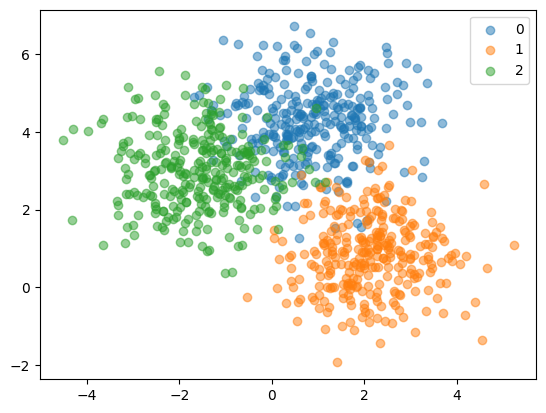

In [12]:
X, y = make_blobs(n_samples=900, centers=3, n_features=2, random_state=0)

where_y_is_0 = X[y == 0]
where_y_is_1 = X[y == 1]
where_y_is_2 = X[y == 2]

plt.scatter(where_y_is_0[:, 0], where_y_is_0[:, 1], alpha=0.5, label='0')
plt.scatter(where_y_is_1[:, 0], where_y_is_1[:, 1], alpha=0.5, label='1')
plt.scatter(where_y_is_2[:, 0], where_y_is_2[:, 1], alpha=0.5, label='2')

plt.legend()
plt.show()

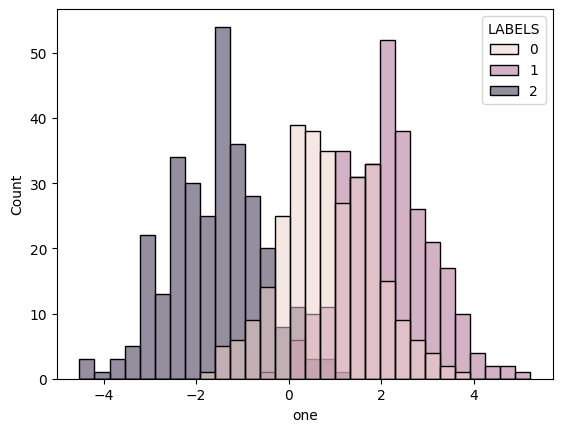

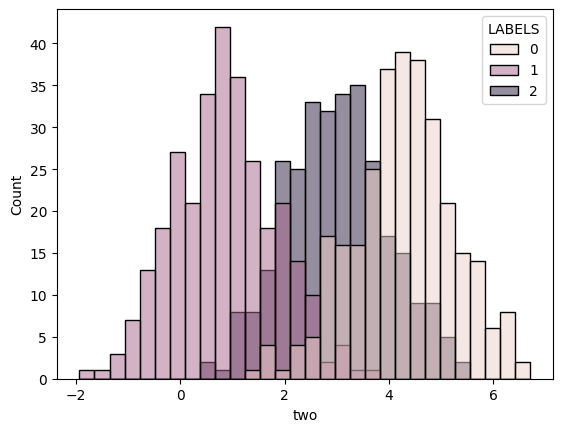

In [13]:
plot_classes(X, y, 1, 'one')
plot_classes(X, y, 2, 'two')

## Exercise 2 - Linear Discriminant Analysis

* Use sklearn's implementation of LDA to project the points in a single dimension and then plot the projected data

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Remember that since we want to project our data onto a vector, the parameter n_components of `LinearDiscriminantAnalysis` should be set to 1

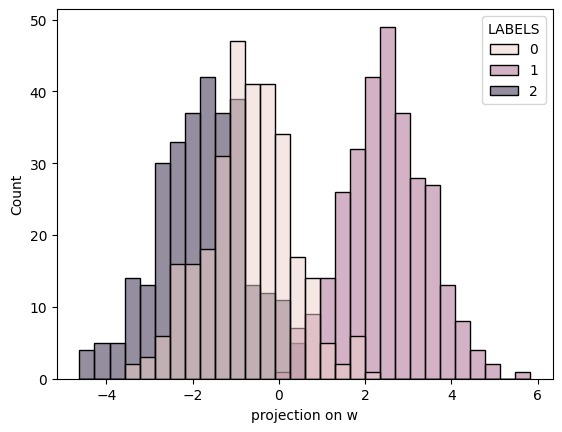

In [15]:
# Some comments are notations for myself
clf = LinearDiscriminantAnalysis(solver='svd', n_components=1)
clf.fit(X, y)

projection = clf.transform(X)  # Matrix W of coefficients described on Bishop's book page 191

plot_classes(projection, y, 1, 'projection on w')

## Exercise 3 - Calculate test set accuracy

* use the default parameters for the LDA classifier, and report the prediction accuracy on a train/test split of 70/30% (use `random_state=0`)
* report also the accuracy of the `RidgeClassfier` you used in Part I 

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=0)

# The projection on W using Ridge Classifier
r = RidgeClassifier()
r.fit(X_train, y_train)
predicted_y_ridge = r.predict(X_test)
accuracy_ridge = accuracy_score(predicted_y_ridge, y_test)

# The projection on W using LinearDiscriminantAnalysis
# Some comments are notations for myself
clf = LinearDiscriminantAnalysis(solver='svd', n_components=1)
clf.fit(X_train, y_train)
predicted_y_lda = clf.predict(X_test)  # Matrix W of coefficients described on Bishop's book page 191
accuracy_lda = accuracy_score(predicted_y_lda, y_test)

print(f"Accuracy LinearDiscriminantAnalysis: {accuracy_lda}")
print(f"Accuracy RidgeClassifier: {accuracy_ridge}")

Accuracy LinearDiscriminantAnalysis: 0.937037037037037
Accuracy RidgeClassifier: 0.9259259259259259
